### Import Library dan Dataset

In [1]:
import os
import gc
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"

In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

I0000 00:00:1768550561.902064  101564 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1768550562.014299  101564 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1768550563.045480  101564 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sorr/anaconda3/envs/nightly_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProg

In [3]:
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
LOCAL_DIR = "../local-indobert-tf"
EPOCHS = 3
BATCH_SIZE = 16
LR = 2e-5
MAX_LEN = 128

In [5]:
# GPU memory growth (safe for tf-nightly)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print("Warning: set_memory_growth failed:", e)

# Mixed precision (optional, often supported in tf-nightly)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision unavailable or failed:", e)

# helper to free memory between trials/folds


def free_mem():
    try:
        tf.keras.backend.clear_session()
    except Exception:
        pass
    gc.collect()


print("TensorFlow version:", tf.__version__)
print("Num GPUs:", len(gpus))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070, compute capability 12.0
Mixed precision enabled: <Policy "mixed_float16">
TensorFlow version: 2.21.0-dev20251013
Num GPUs: 1


W0000 00:00:1768550564.851664  101564 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [6]:
df = pd.read_csv('../data/data_cleaned.csv')
df.head()

,Tweet,Label
0,saya takut kehilangan hal kecil,Takut
1,tidak ada cahaya buat dituju,Sedih
2,rasanya like semuanya sinkron,Gembira
3,yaallah mika angkasa saya kaget saya kira cuma...,Takut
4,saya cemas sejak tadi pagi,Takut


### Persiapan Dataset

In [7]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])
label_names = le.classes_.tolist()
num_labels = len(label_names)

print(f"Total samples: {len(df)}")
print(f"Number of labels: {num_labels}")
print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Total samples: 10075
Number of labels: 5
Label mapping: {'Cinta': np.int64(0), 'Gembira': np.int64(1), 'Marah': np.int64(2), 'Sedih': np.int64(3), 'Takut': np.int64(4)}


In [34]:

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Tweet"].tolist(),
    df["LabelEncoded"].tolist(),
    test_size=0.30,  # 30% = 3000 samples untuk val + test
    stratify=df["LabelEncoded"],
    random_state=SEED
)

# Split temp menjadi val dan test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, 
    temp_labels,
    test_size=0.50,  # 15% dari total = 1500 samples untuk test
    stratify=temp_labels,
    random_state=SEED
)

print(f"Train: {len(train_texts):,} samples")
print(f"Val: {len(val_texts):,} samples")
print(f"Test: {len(test_texts):,} samples (UNTOUCHED)")
print(f"Label distribution in Train: {np.bincount(train_labels)}")
print(f"Label distribution in Val: {np.bincount(val_labels)}")
print(f"Label distribution in Test: {np.bincount(test_labels)}")

Train: 7,052 samples
Val: 1,511 samples
Test: 1,512 samples (UNTOUCHED)
Label distribution in Train: [1167 1681 1432 1405 1367]
Label distribution in Val: [250 360 307 301 293]
Label distribution in Test: [250 361 307 301 293]


### Tokenisasi

In [35]:
tokenizer = AutoTokenizer.from_pretrained(LOCAL_DIR)

def tokenize_texts(texts, max_len=MAX_LEN):
    return tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    
train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)

In [36]:
# Batching dataset
def create_tf_dataset(encodings, labels, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_tf_dataset(train_encodings, train_labels, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = create_tf_dataset(val_encodings, val_labels, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = create_tf_dataset(test_encodings, test_labels, batch_size=BATCH_SIZE, shuffle=False)

### Modelling

In [11]:
def build_model(num_labels=5):
    model = TFAutoModelForSequenceClassification.from_pretrained(
        LOCAL_DIR,
        num_labels=num_labels,
        local_files_only=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

### Cross Validation

In [12]:
fold_texts, test_texts, fold_labels, test_labels = train_test_split(
    df["Tweet"].tolist(),
    df["LabelEncoded"].tolist(),
    test_size=0.15,  # 15% = 1500 samples untuk val + test
    stratify=df["LabelEncoded"],
    random_state=SEED
)

# Split temp menjadi val dan test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    fold_texts,
    fold_labels,
    test_size=0.1765,  # 15% dari total = 1500 samples untuk val
    stratify=fold_labels,
    random_state=SEED
)

fold_labels = np.array(fold_labels)

In [13]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(fold_texts, fold_labels), 1):
    print(f"\n===== Fold {fold} =====")

    X_train = [fold_texts[i] for i in train_idx]
    y_train = fold_labels[train_idx]
    X_val = [fold_texts[i] for i in val_idx]
    y_val = fold_labels[val_idx]

    train_enc = tokenize_texts(X_train)
    val_enc = tokenize_texts(X_val)

    model = build_model(num_labels=5)

    model.fit(
        x=dict(train_enc),
        y=y_train,
        validation_data=(dict(val_enc), y_val),
        batch_size=32,
        epochs=3,
        verbose=1
    )

    # Prediction
    val_logits = model.predict(dict(val_enc)).logits
    val_preds = np.argmax(val_logits, axis=1)

    acc = accuracy_score(y_val, val_preds)
    f1 = f1_score(y_val, val_preds, average='macro')

    fold_results.append({
        "fold": fold,
        "accuracy": acc,
        "macro_f1": f1
    })

    print(f"Fold {fold} | Acc: {acc:.4f} | Macro-F1: {f1:.4f}")
    free_mem()


===== Fold 1 =====


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Epoch 1/3


E0000 00:00:1768550584.111855  101564 util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1768550585.644309  101674 service.cc:158] XLA service 0x7c495002cbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768550585.644350  101674 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1768550585.664117  101672 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1768550585.688452  101672 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1768550585.785848  101680 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 [==============================] - 74s 244ms/step - loss: 0.8437 - accuracy: 0.7130 - val_loss: 0.3686 - val_accuracy: 0.8809
Epoch 2/3
215/215 [==============================] - 46s 214ms/step - loss: 0.3403 - accuracy: 0.8909 - val_loss: 0.3258 - val_accuracy: 0.8973
Epoch 3/3
54/54 [==============================] - 5s 70ms/step
Fold 1 | Acc: 0.8996 | Macro-F1: 0.8990

===== Fold 2 =====


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Epoch 1/3
215/215 [==============================] - 73s 242ms/step - loss: 0.8453 - accuracy: 0.7042 - val_loss: 0.3948 - val_accuracy: 0.8698
Epoch 2/3
215/215 [==============================] - 46s 214ms/step - loss: 0.3443 - accuracy: 0.8896 - val_loss: 0.3438 - val_accuracy: 0.8797
Epoch 3/3
54/54 [==============================] - 5s 67ms/step
Fold 2 | Acc: 0.8943 | Macro-F1: 0.8940

===== Fold 3 =====


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Epoch 1/3
215/215 [==============================] - 69s 241ms/step - loss: 0.8486 - accuracy: 0.7099 - val_loss: 0.3963 - val_accuracy: 0.8646
Epoch 2/3
215/215 [==============================] - 45s 210ms/step - loss: 0.3349 - accuracy: 0.8896 - val_loss: 0.3493 - val_accuracy: 0.8797
Epoch 3/3
54/54 [==============================] - 5s 71ms/step
Fold 3 | Acc: 0.8821 | Macro-F1: 0.8806

===== Fold 4 =====


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Epoch 1/3
215/215 [==============================] - 74s 239ms/step - loss: 0.8569 - accuracy: 0.7063 - val_loss: 0.3894 - val_accuracy: 0.8814
Epoch 2/3
215/215 [==============================] - 46s 213ms/step - loss: 0.3371 - accuracy: 0.8936 - val_loss: 0.3411 - val_accuracy: 0.8855
Epoch 3/3
54/54 [==============================] - 5s 68ms/step
Fold 4 | Acc: 0.8884 | Macro-F1: 0.8876

===== Fold 5 =====


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Epoch 1/3
215/215 [==============================] - 69s 224ms/step - loss: 0.8328 - accuracy: 0.7190 - val_loss: 0.4384 - val_accuracy: 0.8499
Epoch 2/3
215/215 [==============================] - 42s 197ms/step - loss: 0.3349 - accuracy: 0.8924 - val_loss: 0.3824 - val_accuracy: 0.8709
Epoch 3/3
54/54 [==============================] - 5s 66ms/step
Fold 5 | Acc: 0.8738 | Macro-F1: 0.8732


In [14]:
accs = [r["accuracy"] for r in fold_results]
f1s = [r["macro_f1"] for r in fold_results]

print("\n===== K-FOLD SUMMARY =====")
print(f"Folds: {len(fold_results)}")
print(f"Accuracy per fold: {[f'{r['accuracy']:.4f}' for r in fold_results]}")
print(f"Macro-F1 per fold: {[f'{r['macro_f1']:.4f}' for r in fold_results]}")
print(f"Mean Accuracy : {np.mean(accs):.4f}")
print(f"Mean Macro-F1 : {np.mean(f1s):.4f}")


===== K-FOLD SUMMARY =====
Folds: 5
Accuracy per fold: ['0.8996', '0.8943', '0.8821', '0.8884', '0.8738']
Macro-F1 per fold: ['0.8990', '0.8940', '0.8806', '0.8876', '0.8732']
Mean Accuracy : 0.8877
Mean Macro-F1 : 0.8869


### Fine Tuning

In [15]:
model = build_model(num_labels=num_labels)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Epoch 1/3
441/441 [==============================] - 98s 179ms/step - loss: 0.6786 - accuracy: 0.7677 - val_loss: 0.4069 - val_accuracy: 0.8650
Epoch 2/3
441/441 [==============================] - 74s 167ms/step - loss: 0.2936 - accuracy: 0.9022 - val_loss: 0.3674 - val_accuracy: 0.8822
Epoch 3/3
441/441 [==============================] - 73s 165ms/step - loss: 0.2091 - accuracy: 0.9322 - val_loss: 0.3658 - val_accuracy: 0.8802


### Evaluasi

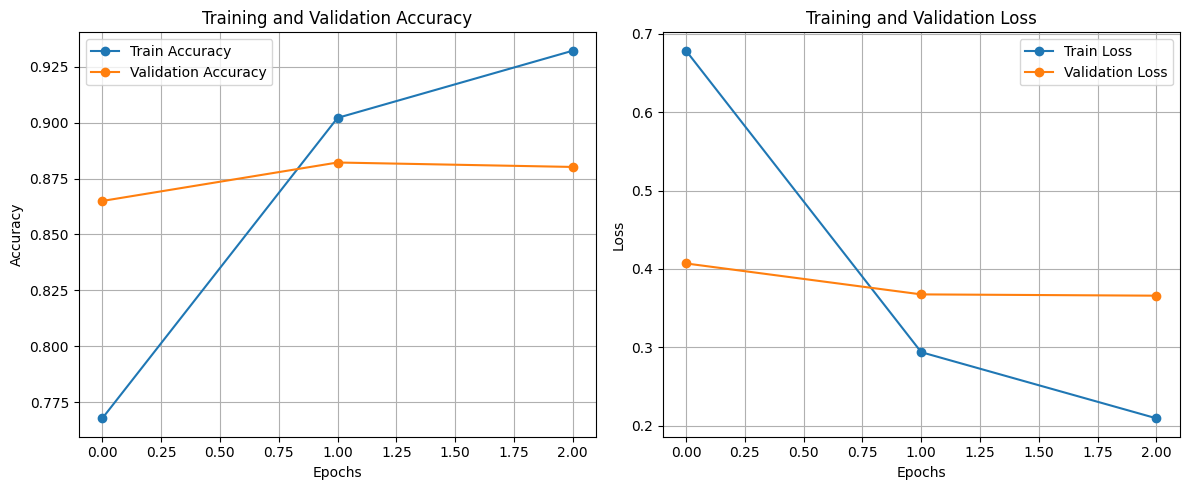

In [16]:
# Visualisasi Learning Curve
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'],
         label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")




FINAL RESULTS
Test Loss: 0.3444
Test Accuracy: 0.8909


In [38]:
# Predictions dan detailed report
pred_logits = model.predict(test_dataset, verbose=0).logits
pred_labels = np.argmax(pred_logits, axis=1)

print("\nCLASSIFICATION REPORT:")
print(classification_report(test_labels, pred_labels,
                            target_names=label_names, digits=4))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Cinta     0.8493    0.9240    0.8851       250
     Gembira     0.9162    0.8781    0.8967       361
       Marah     0.8704    0.9186    0.8938       307
       Sedih     0.9065    0.8372    0.8705       301
       Takut     0.9075    0.9044    0.9060       293

    accuracy                         0.8909      1512
   macro avg     0.8900    0.8925    0.8904      1512
weighted avg     0.8922    0.8909    0.8908      1512



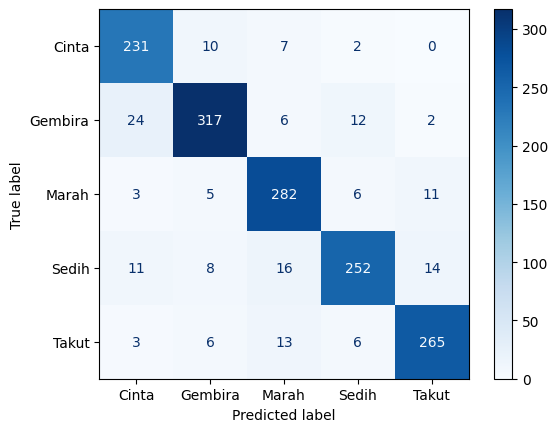

In [39]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)

In [20]:
SAVE_DIR = "./IndoBert_Model"

os.makedirs(SAVE_DIR, exist_ok=True)

model.save_pretrained(f'{SAVE_DIR}',save_format="tf")
tokenizer.save_pretrained(f'{SAVE_DIR}',save_format="tf")

('./IndoBert_Model/tokenizer_config.json',
 './IndoBert_Model/special_tokens_map.json',
 './IndoBert_Model/vocab.txt',
 './IndoBert_Model/added_tokens.json',
 './IndoBert_Model/tokenizer.json')

### Inferensi Model

In [21]:
MODEL_PATH = SAVE_DIR
TOKENIZER_PATH = SAVE_DIR

In [22]:
#Load tokenizer dan model
inference_tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
inference_model = TFAutoModelForSequenceClassification.from_pretrained(SAVE_DIR)

Some layers from the model checkpoint at ./IndoBert_Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./IndoBert_Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [23]:
EXTERNAL_TEST_PATH = "../data/external_test.csv"


# Load external dataset
external_df = pd.read_csv(EXTERNAL_TEST_PATH)

# Cek struktur dataset
print(f"External dataset shape: {external_df.shape}")
print(f"Columns: {external_df.columns.tolist()}")
print(f"\n First few rows:")
print(external_df.head())

print(f"\nClass distribution in external data:")
print(external_df['Label'].value_counts())

External dataset shape: (1932, 2)
Columns: ['Label', 'Tweet']

 First few rows:
   Label                                          Tweet
0  Cinta          rasanya mirip hati saya disusun ulang
1  Cinta      rasanya mirip saya diselimuti rasa sayang
2  Cinta  rasanya mirip hati saya ditempel spark lembut
3  Cinta           saya suka tiap dia bilang saya cukup
4  Cinta           saya suka tiap dia ngulang kata saya

Class distribution in external data:
Label
Gembira    695
Sedih      580
Marah      275
Takut      223
Cinta      159
Name: count, dtype: int64


In [24]:
# Cek label yang ada di external data
external_labels = external_df['Label'].unique()
print(f"Unique labels in external data: {external_labels}")

Unique labels in external data: ['Cinta' 'Gembira' 'Marah' 'Sedih' 'Takut']


In [25]:
le.fit(label_names)  # Fit dengan label names yang konsisten

external_df['LabelEncoded'] = le.transform(external_df['Label'])
print(f"Final external dataset: {len(external_df)} samples")

Final external dataset: 1932 samples


In [26]:
# Tokenisasi external data
external_texts = external_df['Tweet'].tolist()
external_true_labels = external_df['LabelEncoded'].tolist()

def inference_tokenize_texts(texts, max_len=MAX_LEN):
    return inference_tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

external_encodings = inference_tokenize_texts(external_texts)

# Buat dataset
external_dataset = tf.data.Dataset.from_tensor_slices((
    dict(external_encodings),
    tf.convert_to_tensor(external_true_labels)
)).batch(16).prefetch(tf.data.AUTOTUNE)

In [27]:
# Recompile model
inference_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LR), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [28]:
# Evaluate model
external_loss, external_accuracy = inference_model.evaluate(external_dataset, verbose=0)

print("\n" + "="*60)
print("EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE")
print("="*60)
print(f"External Test Loss: {external_loss:.4f}")
print(f"External Test Accuracy: {external_accuracy:.4f}")
print(f"Number of samples: {len(external_df)}")


EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE
External Test Loss: 0.4360
External Test Accuracy: 0.8540
Number of samples: 1932


In [29]:
# Predictions
pred_logits = inference_model.predict(external_dataset, verbose=0).logits
pred_labels = np.argmax(pred_logits, axis=1)
pred_probs = tf.nn.softmax(pred_logits, axis=1)

# Classification Report
print("\nCLASSIFICATION REPORT (External Data):")
print(classification_report(
    external_true_labels,
    pred_labels,
    target_names=label_names,
    digits=4
))


CLASSIFICATION REPORT (External Data):
              precision    recall  f1-score   support

       Cinta     0.6114    0.8805    0.7216       159
     Gembira     0.9422    0.8921    0.9165       695
       Marah     0.7840    0.9636    0.8646       275
       Sedih     0.9707    0.7414    0.8407       580
       Takut     0.7386    0.8744    0.8008       223

    accuracy                         0.8540      1932
   macro avg     0.8094    0.8704    0.8288      1932
weighted avg     0.8775    0.8540    0.8570      1932



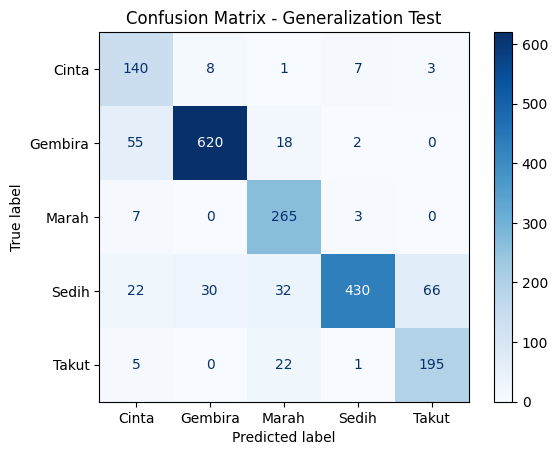

In [30]:
# Confusion Matrix
cm = confusion_matrix(external_true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title(
    "Confusion Matrix - Generalization Test")
plt.show()